### 读文件
- 1.休息西
### 传入模型出热图
### 保存结果 

In [97]:
import argparse
import sys
import os.path

import torch
import torch.nn    as nn

import h5py as h5
import SimpleITK as sitk
from PIL import Image

In [98]:
cur_path = os.path.abspath(".")
data_path = os.path.join(cur_path,'data')
print(f"cur_path:{cur_path}")
print(f"data_path:{data_path}")

cur_path:/home/xindong/project/rg2-work
data_path:/home/xindong/project/rg2-work/data


In [99]:
img = sitk.ReadImage(os.path.join(data_path,'image006.nii.gz'))
print(img.GetSize())
xray_data = sitk.GetArrayFromImage(img)

print(type(xray_data),xray_data.shape)

(1536, 1536)
<class 'numpy.ndarray'> (1536, 1536)


<function matplotlib.pyplot.show(close=None, block=None)>

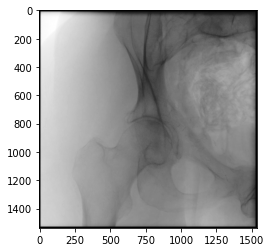

In [100]:
import matplotlib.pyplot as plt

plt.imshow(xray_data[:,:],cmap='gray')
plt.show

## Utilities

In [101]:
# General utility functions
#
# Copyright (C) 2019-2020 Robert Grupp (grupp@jhu.edu)
#
# You should have received a copy of the GNU General Public License
# along with this program. If not, see <https://www.gnu.org/licenses/>.

import time
import math

import torch
import torch.nn as nn

from torch.utils.data import DataLoader

from dice import *

def get_gaussian_2d_heatmap(num_rows, num_cols, sigma, peak_row=None, peak_col=None):
    if peak_row is None:
        peak_row = num_rows // 2
    if peak_col is None:
        peak_col = num_cols // 2
    
    (Y,X) = torch.meshgrid(torch.arange(0,num_rows), torch.arange(0,num_cols))
    
    Y = Y.float()
    X = X.float()

    return torch.exp(((X - peak_col).pow(2) + (Y - peak_row).pow(2)) / (sigma * sigma * -2)) / (2 * math.pi * sigma * sigma)

def write_floats_to_txt(file_path, floats):
    with open(file_path,'w') as out:
        for f in floats:
            out.write('{:.6f}\n'.format(f))
        out.flush()

def read_floats_from_txt(file_path):
    return torch.Tensor([float(l.strip()) for l in open(file_path).readlines()])

class RunningFloatWriter:
    def __init__(self, file_path, new_file=True):
        super(RunningFloatWriter,self).__init__()

        write_mode = 'w'
        if not new_file:
            write_mode = 'a'

        self.out = open(file_path, write_mode)

    def write(self, x):
        self.out.write('{:.6f}\n'.format(x))
        self.out.flush()

    def close(self):
        if self.out:
            self.out.flush()
            self.out.close()
            self.out = None

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.close()

    def __del__(self):
        self.close()


def center_crop(img, dst_shape):
    src_nr = img.shape[-2]
    src_nc = img.shape[-1]

    dst_nr = dst_shape[-2]
    dst_nc = dst_shape[-1]
    
    if (dst_nr != src_nr) or (dst_nc != src_nc):
        src_start_r = int((src_nr - dst_nr) / 2)
        src_end_r   = src_start_r + dst_nr
        
        src_start_c = int((src_nc - dst_nc) / 2)
        src_end_c   = src_start_c + dst_nc
        
        if img.dim() == 4:
            return img[:,:,src_start_r:src_end_r,src_start_c:src_end_c]
        elif img.dim() == 3:
            return img[:,src_start_r:src_end_r,src_start_c:src_end_c]
        else:
            assert(img.dim() == 2)
            return img[src_start_r:src_end_r,src_start_c:src_end_c]
    else:
        return img

def test_dataset(ds, net, dev=None, num_lands=0):
    dl = DataLoader(ds, batch_size=1, shuffle=False)
    
    with torch.no_grad():
        net.eval()

        losses = torch.zeros(len(ds))
        
        num_items = 0
    
        if num_lands > 0:
            criterion = DiceAndHeatMapLoss2D(skip_bg=False)
        else:
            criterion = DiceLoss2D(skip_bg=False)

        for (i, data) in enumerate(dl, 0):
            (projs, masks, lands, heats) = data
            
            if dev is not None:
                projs = projs.to(dev)
                masks = masks.to(dev)
                if num_lands > 0:
                    if len(heats.shape) > 4:
                        assert(len(heats.shape) == 5)
                        assert(heats.shape[2] == 1)
                        heats = heats.view(heats.shape[0], heats.shape[1], heats.shape[3], heats.shape[4])
                    heats = heats.to(dev)

            net_out = net(projs)
            if (num_lands > 0) or (type(net_out) is tuple):
                pred_masks     = net_out[0]
                pred_heat_maps = net_out[1]
            else:
                pred_masks = net_out

            pred_masks = center_crop(pred_masks, masks.shape)
            
            if num_lands > 0:
                pred_heat_maps = center_crop(pred_heat_maps, heats.shape)
                loss = criterion((pred_masks, pred_heat_maps), (masks, heats))
            else:
                loss = criterion(pred_masks, masks)

            losses[i] = loss.item()

            num_items += 1
        
        assert(num_items == len(ds))

        return (torch.mean(losses), torch.std(losses))

def test_dataset_ensemble(ds, nets, dev=None, num_lands=0, dice_only=False):
    num_nets = len(nets)

    dl = DataLoader(ds, batch_size=1, shuffle=False)
    
    with torch.no_grad():
        for net in nets:
            net.eval()

        losses = torch.zeros(len(ds))
        
        num_items = 0
    
        if not dice_only and (num_lands > 0):
            criterion = DiceAndHeatMapLoss2D(skip_bg=False)
        else:
            criterion = DiceLoss2D(skip_bg=False)

        for (i, data) in enumerate(dl, 0):
            (projs, masks, lands, heats) = data
            
            if dev is not None:
                projs = projs.to(dev)
                masks = masks.to(dev)
                if num_lands > 0:
                    if len(heats.shape) > 4:
                        assert(len(heats.shape) == 5)
                        assert(heats.shape[2] == 1)
                        heats = heats.view(heats.shape[0], heats.shape[1], heats.shape[3], heats.shape[4])
                    heats = heats.to(dev)

            avg_masks = None
            avg_heats = None

            for net in nets:
                net_out = net(projs)
                if (num_lands > 0) or (type(net_out) is tuple):
                    pred_masks     = net_out[0]
                    pred_heat_maps = net_out[1]
                else:
                    pred_masks = net_out

                pred_masks = center_crop(pred_masks, masks.shape)

                if avg_masks is None:
                    avg_masks = pred_masks
                else:
                    avg_masks += pred_masks
            
                if num_lands > 0:
                    pred_heat_maps = center_crop(pred_heat_maps, heats.shape)

                    if avg_heats is None:
                        avg_heats = pred_heat_maps
                    else:
                        avg_heats += pred_heat_maps
            # end for net
            
            avg_masks /= num_nets

            if num_lands > 0:
                avg_heats /= num_nets

            if not dice_only and (num_lands > 0):
                loss = criterion((avg_masks, avg_heats), (masks, heats))
            else:
                loss = criterion(avg_masks, masks)

            losses[i] = loss.item()

            num_items += 1
        
        assert(num_items == len(ds))

        return (torch.mean(losses), torch.std(losses))

def seg_dataset(ds, net, h5_f, dev=None, num_lands=0):
    orig_img_shape = ds.rob_orig_img_shape
    
    dl = DataLoader(ds, batch_size=1, shuffle=False)
   
    dst_ds = h5_f.create_dataset('nn-segs', (len(ds), *orig_img_shape),
                                 dtype='u1',
                                 chunks=(1, *orig_img_shape),
                                 compression="gzip", compression_opts=9)
    
    dst_heats_ds = None

    if num_lands > 0:
        dst_heats_ds = h5_f.create_dataset('nn-heats', (len(ds), num_lands, *orig_img_shape),
                                           chunks=(1,1,*orig_img_shape),
                                           compression="gzip", compression_opts=9)

    with torch.no_grad():
        net.eval()

        num_items = 0
        
        for (i, data) in enumerate(dl, 0):
            projs = data[0]

            if dev is not None:
                projs = projs.to(dev)

            net_out = net(projs)
            if (num_lands > 0) or (type(net_out) is tuple):
                pred_masks = net_out[0]
                pred_heats = net_out[1]
            else:
                pred_masks = net_out

            pred_masks = center_crop(pred_masks, orig_img_shape)

            (_, pred_masks) = torch.max(pred_masks, dim=1)
   
            # write to file
            dst_ds[i,:,:] = pred_masks.view(orig_img_shape).cpu().numpy()

            if dst_heats_ds is not None:
                dst_heats_ds[i,:,:,:] = center_crop(pred_heats, orig_img_shape).numpy()

            num_items += 1
        
        assert(num_items == len(ds))


def seg_dataset_ensemble(ds, nets, h5_f, dev=None, num_lands=0, times=None):
    num_nets = len(nets)

    orig_img_shape = ds.rob_orig_img_shape
    
    dl = DataLoader(ds, batch_size=1, shuffle=False)
   
    dst_ds = h5_f.create_dataset('nn-segs', (len(ds), *orig_img_shape),
                                 dtype='u1',
                                 chunks=(1, *orig_img_shape),
                                 compression="gzip", compression_opts=9)
    
    dst_heats_ds = None

    if num_lands > 0:
        dst_heats_ds = h5_f.create_dataset('nn-heats', (len(ds), num_lands, *orig_img_shape),
                                           chunks=(1,1,*orig_img_shape),
                                           compression="gzip", compression_opts=9)

    with torch.no_grad():
        for net in nets:
            net.eval()

        num_items = 0
        
        for (i, data) in enumerate(dl, 0):
            projs = data[0]
            
            start_time = time.time()

            if dev is not None:
                projs = projs.to(dev)

            avg_masks = None
            
            avg_heats = None

            for net in nets:
                net_out = net(projs)
                if (num_lands > 0) or (type(net_out) is tuple):
                    pred_masks = net_out[0]
                    pred_heats = net_out[1]
                else:
                    pred_masks = net_out

                pred_masks = center_crop(pred_masks, orig_img_shape)

                if avg_masks is None:
                    avg_masks = pred_masks
                else:
                    avg_masks += pred_masks
            
                if dst_heats_ds is not None:
                    pred_heats = center_crop(pred_heats, orig_img_shape)
                    
                    pred_heats_min = pred_heats.min().item()
                    pred_heats_max = pred_heats.max().item()
                    
                    pred_heats = (pred_heats - pred_heats_min) / (pred_heats_max - pred_heats_min)

                    if avg_heats is None:
                        avg_heats = pred_heats
                    else:
                        avg_heats += pred_heats
            
            # technically we don't need to do this for the segmentation
            avg_masks /= num_nets

            (_, pred_masks) = torch.max(avg_masks, dim=1)
            
            stop_time = time.time()

            if times is not None:
                times.append(stop_time - start_time)

            # write to file
            dst_ds[i,:,:] = pred_masks.view(orig_img_shape).cpu().numpy()
            
            if dst_heats_ds is not None:
                avg_heats /= num_nets
                dst_heats_ds[i,:,:,:] = avg_heats.cpu().numpy()

            num_items += 1
        
        assert(num_items == len(ds))




## dataset

In [102]:
# Dataloading utilities from preprocessed HDF5 files.
#
# Copyright (C) 2019-2020 Robert Grupp (grupp@jhu.edu)
#
# You should have received a copy of the GNU General Public License
# along with this program. If not, see <https://www.gnu.org/licenses/>.

import math
import random

import h5py as h5

import torch
import torch.utils.data

import torchvision.transforms.functional as TF

import numpy as np

import PIL

# from util import *
            
def calc_pad_amount(padded_img_dim, cur_img_dim):
    # new pad dimension should be larger
    assert(padded_img_dim > cur_img_dim)

    # first calculate the amount to pad along the borders
    pad = (padded_img_dim - cur_img_dim)/ 2

    # handle odd sized input
    if pad != int(pad):
        pad = int(pad) + 1
    else:
        # needs to be integral
        pad = int(pad)

    return pad

class RandomDataAugDataSet(torch.utils.data.Dataset):
    def __init__(self, projs, segs, lands=None, proj_pad_dim=0):
        self.projs = projs
        self.segs  = segs
        self.lands = lands
   
        assert(len(projs.shape) == 4)
        assert(projs.shape[1] == 1)

        if segs is not None:
            assert(len(projs.shape) == len(segs.shape))
            assert(projs.shape[0] == segs.shape[0])
            
            # initial sizes before padding should be equal
            assert(projs.shape[2] == segs.shape[2])
            assert(projs.shape[3] == segs.shape[3])
        
        if lands is not None:
            assert(projs.shape[0] == lands.shape[0])
            assert(lands.shape[1] == 2)

        self.prob_of_aug = 0.5
        #self.prob_of_aug = 1.0

        self.do_invert = True
        self.do_gamma  = True
        self.do_noise  = True
        self.do_affine = True
        self.do_erase  = True

        self.erase_prob = 0.25

        self.pad_data_for_affine = True

        self.do_norm_01_scale = True

        self.include_heat_map = True

        self.print_aug_info = False

        self.extra_pad = 0
        if proj_pad_dim > 0:
            # only support square images for now
            assert(projs.shape[-1] == projs.shape[-2])
            self.extra_pad = calc_pad_amount(proj_pad_dim, projs.shape[-1])

    def __len__(self):
        return self.projs.shape[0]

    def __getitem__(self, i):
        assert(type(i) is int)

        p = self.projs[i,:,:,:]

        s = None
        if self.segs is not None:
            s = self.segs[i,:,:,:]

        cur_lands = None
        if self.lands is not None:
            # we need a deep copy here because of possible data aug
            cur_lands = self.lands[i,:,:].clone()

        need_to_pad_proj = self.extra_pad > 0

        if (self.prob_of_aug > 0) and (random.random() < self.prob_of_aug): 
            #print('augmenting...')

            if self.do_invert and (random.random() < 0.5):
                #print('  inversion...')

                p_max = p.max()
                #p_min = p.min()
                p = p_max - p

                if self.print_aug_info:
                    print('inverting')

            if self.do_noise:
                # normalize to [0,1] to apply noise
                p_min = p.min()
                p_max = p.max()

                p = (p - p_min) / (p_max - p_min)

                cur_noise_sigma = random.uniform(0.005, 0.01)
                p += torch.randn(p.shape) * cur_noise_sigma
                
                p = (p * (p_max - p_min)) + p_min

                if self.print_aug_info:
                    print('noise sigma: {:.3f}'.format(cur_noise_sigma))

            if self.do_gamma:
                # normalize to [0,1] to apply gamma
                p_min = p.min()
                p_max = p.max()

                p = (p - p_min) / (p_max - p_min)

                gamma = random.uniform(0.7,1.3)
                p.pow_(gamma)

                p = (p * (p_max - p_min)) + p_min

                if self.print_aug_info:
                    print('gamma = {:.2f}'.format(gamma))
       
            if self.do_affine:
                # data needs to be in [0,1] for PIL functions
                p_min = p.min()
                p_max = p.max()

                p = (p - p_min) / (p_max - p_min)
                
                orig_p_shape = p.shape
                if self.pad_data_for_affine:
                    pad1 = int(math.ceil(orig_p_shape[1] / 2.0))
                    pad2 = int(math.ceil(orig_p_shape[2] / 2.0))
                    if need_to_pad_proj:
                        pad1 += self.extra_pad
                        pad2 += self.extra_pad
                        need_to_pad_proj = False

                    p = torch.from_numpy(np.pad(p.numpy(),
                                                ((0,0), (pad1,pad1), (pad2,pad2)),
                                                'reflect'))
                
                p_il = TF.to_pil_image(p)

                # this uniformly samples the direction
                rand_trans = torch.randn(2)
                rand_trans /= rand_trans.norm()

                # now uniformly sample the magnitdue
                rand_trans *= random.random() * 20
                
                rot_ang = random.uniform(-5, 5)
                trans_x = rand_trans[0]
                trans_y = rand_trans[1]
                shear_x   = random.uniform(-2, 2)
                shear_y   = random.uniform(-2, 2)
                shear   = [shear_x,shear_x]
                
                scale_factor = random.uniform(0.9, 1.1)

                if self.print_aug_info:
                    print('Rot: {:.2f}'.format(rot_ang))
                    print('Trans X: {:.2f} , Trans Y: {:.2f}'.format(trans_x, trans_y))
                    print('Shear X: {:.2f},  Shaer Y: {:.2f}'.format(shear_x,shear_y))
                    print('Scale: {:.2f}'.format(scale_factor))

                p = TF.to_tensor(TF.affine(TF.to_pil_image(p),
                                 rot_ang,
                                 (trans_x, trans_y),
                                 scale_factor,
                                 shear,
                                 resample=PIL.Image.BILINEAR))
                
                if self.pad_data_for_affine:
                    # pad can be zero
                    pad_shape = (orig_p_shape[-2] + (2 * self.extra_pad), orig_p_shape[-1] + (2 * self.extra_pad))
                    p = center_crop(p, pad_shape)

                p = (p * (p_max - p_min)) + p_min

                if s is not None:
                    orig_s_shape = s.shape
                    if self.pad_data_for_affine:
                        pad1 = int(math.ceil(orig_s_shape[1] / 2.0))
                        pad2 = int(math.ceil(orig_s_shape[2] / 2.0))
                        s = torch.from_numpy(np.pad(s.numpy(),
                                                    ((0,0), (pad1,pad1), (pad2,pad2)),
                                                    'reflect'))
                    
                    # warp each class separately, I don't want any wacky color
                    # spaces assumed by PIL
                    for c in range(s.shape[0]):
                        s[c,:,:] = TF.to_tensor(TF.affine(TF.to_pil_image(s[c,:,:]),
                                                          rot_ang,
                                                          (trans_x, trans_y),
                                                          scale_factor,
                                                          shear))
                    if self.pad_data_for_affine:
                        s = center_crop(s, orig_s_shape)
                
                if cur_lands is not None:
                    shape_for_center_of_rot = s.shape if s is not None else p.shape

                    center_of_rot = ((shape_for_center_of_rot[-2] / 2.0) + 0.5,
                                     (shape_for_center_of_rot[-1] / 2.0) + 0.5)
                    
                    A_inv = TF._get_inverse_affine_matrix(center_of_rot, rot_ang, (trans_x, trans_y), scale_factor, shear)
                    A = np.matrix([ [A_inv[0], A_inv[1], A_inv[2]], [A_inv[3], A_inv[4], A_inv[5]], [0,0,1]]).I

                    for pt_idx in range(cur_lands.shape[-1]):
                        cur_land = cur_lands[:,pt_idx]
                        if (not math.isinf(cur_land[0])) and (not math.isinf(cur_land[1])):
                            tmp_pt = A * np.asmatrix(np.pad(cur_land.numpy(), (0,1), mode='constant', constant_values=1).reshape(3,1))
                            xform_l = torch.from_numpy(np.squeeze(np.asarray(tmp_pt))[0:2])
                            if (s is not None) and \
                               ((xform_l[0] < 0) or (xform_l[0] > (orig_s_shape[1] - 1)) or \
                                (xform_l[1] < 0) or (xform_l[1] < (orig_s_shape[0] - 1))):
                                xform_l[0] = math.inf
                                xform_l[1] = math.inf
                            
                            cur_lands[:,pt_idx] = xform_l
            
            if self.do_erase and (random.random() < self.erase_prob):
                #print('  box noise/erase...')

                p_2d_shape = [p.shape[-2], p.shape[-1]]
                box_mean_dim = torch.Tensor([p_2d_shape[0] * 0.15, p_2d_shape[1] * 0.15])
                
                num_boxes = random.randint(1,5)
                
                if self.print_aug_info:
                    print('  Random Corrupt: num. boxes: {}'.format(num_boxes))
                
                for box_idx in range(num_boxes):
                    box_valid = False
                    
                    while not box_valid:
                        # First sample box dims
                        box_dims = torch.round((torch.randn(2) * (box_mean_dim)) + box_mean_dim).long()

                        if (box_dims[0] > 0) and (box_dims[1] > 0) and \
                                (box_dims[0] <= p_2d_shape[0]) and (box_dims[1] <= p_2d_shape[1]):
                            # Next sample box location
                            start_row = random.randint(0, p_2d_shape[0] - box_dims[0])
                            start_col = random.randint(0, p_2d_shape[1] - box_dims[1])

                            box_valid = True
                    
                    p_roi = p[0,start_row:(start_row+box_dims[0]),start_col:(start_col+box_dims[1])]

                    sigma_noise = (p_roi.max() - p_roi.min()) * 0.2
                    
                    p_roi += torch.randn(p_roi.shape) * sigma_noise

        # end data aug

        if need_to_pad_proj:
            p = torch.from_numpy(np.pad(p.numpy(),
                                 ((0, 0), (self.extra_pad, self.extra_pad), (self.extra_pad, self.extra_pad)),
                                 'reflect'))

        if self.do_norm_01_scale:
            p = (p - p.mean()) / p.std()

        h = None
        if self.include_heat_map:
            assert(s is not None)
            assert(cur_lands is not None)

            num_lands = cur_lands.shape[-1]

            h = torch.zeros(num_lands, 1, s.shape[-2], s.shape[-1])

            # "FH-l", "FH-r", "GSN-l", "GSN-r", "IOF-l", "IOF-r", "MOF-l", "MOF-r", "SPS-l", "SPS-r", "IPS-l", "IPS-r"
            #sigma_lut = [ 2.5, 2.5, 7.5, 7.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]
            sigma_lut = torch.full([num_lands], 2.5)

            (Y,X) = torch.meshgrid(torch.arange(0, s.shape[-2]),
                                   torch.arange(0, s.shape[-1]))
            Y = Y.float()
            X = X.float()

            for land_idx in range(num_lands):
                sigma = sigma_lut[land_idx]

                cur_land = cur_lands[:,land_idx]

                mu_x = cur_land[0]
                mu_y = cur_land[1]

                if not math.isinf(mu_x) and not math.isinf(mu_y):
                    pdf = torch.exp(((X - mu_x).pow(2) + (Y - mu_y).pow(2)) / (sigma * sigma * -2)) / (2 * math.pi * sigma * sigma)
                    #pdf /= pdf.sum() # normalize to sum of 1
                    h[land_idx,0,:,:] = pdf
            #assert(torch.all(torch.isfinite(h)))

        return (p,s,cur_lands,h)

def get_orig_img_shape(h5_file_path, pat_ind):
    f = h5.File(h5_file_path, 'r')
        
    s = f['{:02d}/projs'.format(pat_ind)].shape
    
    assert(len(s) == 3)
    
    return (s[1], s[2])

def get_num_lands_from_dataset(h5_file_path):
    f = h5.File(h5_file_path, 'r')
    
    num_lands = int(f['land-names/num-lands'][()])

    f.close()

    return num_lands

def get_land_names_from_dataset(h5_file_path):
    f = h5.File(h5_file_path, 'r')
    
    num_lands = int(f['land-names/num-lands'][()])

    land_names = []

    for l in range(num_lands):
        s = f['land-names/land-{:02d}'.format(l)][()]
        if (type(s) is bytes) or (type(s) is np.bytes_):
            s = s.decode()
        assert(type(s) is str)

        land_names.append(s)
    
    f.close()

    return land_names


def get_dataset(h5_file_path, pat_inds, num_classes,
                pad_img_dim=0, no_seg=False,
                minmax=None,
                data_aug=False,
                train_valid_split=None,
                train_valid_idx=None,
                dup_data_w_left_right_flip=False):
    # classes:
    # 0 --> BG
    # 1 --> Pelvis
    # 2 --> Left Femur
    # 3 --> Right Femur
        
    need_to_scale_data   = False
    need_to_find_min_max = False

    if minmax is not None:
        if (type(minmax) is bool) and minmax:
            need_to_scale_data = True
            print('need to find min/max for preprocessing...')
            need_to_find_min_max = True
            minmax_min =  math.inf
            minmax_max = -math.inf
        elif type(minmax) is tuple:
            minmax_min = minmax[0]
            minmax_max = minmax[1]
            need_to_scale_data = True
            print('using provided min/max for preprocessing: ({}, {})'.format(minmax_min, minmax_max))

    f = h5.File(h5_file_path, 'r')

    all_projs = None
    all_segs  = None
    all_lands = None

    orig_img_shape = None

    for pat_idx in pat_inds:
        pat_g = f['{:02d}'.format(pat_idx)]

        cur_projs_np = pat_g['projs'][:]
        assert(len(cur_projs_np.shape) == 3)
        print(f"cur_projs_np shape={cur_projs_np.shape}")

        if orig_img_shape is None:
            orig_img_shape = (cur_projs_np.shape[1], cur_projs_np.shape[2])#180*180
        else:
            assert(orig_img_shape[0] == cur_projs_np.shape[1])
            assert(orig_img_shape[1] == cur_projs_np.shape[2])
        
        cur_lands = torch.from_numpy(pat_g['lands'][:])
        assert(cur_lands.shape[0] == cur_projs_np.shape[0])
        assert(torch.all(torch.isfinite(cur_lands)))  # all inputs should be finite

        print(f"cur_lands shape={cur_lands.shape}")#Size([111, 2, 14])
        print(f"orig_img_shape shape=({orig_img_shape[0]},{orig_img_shape[1]})")

        # mark out of bounds landmarks with inf's
        #不合法的数据直接设为math.inf
        for img_idx in range(cur_lands.shape[0]):
            for l_idx in range(cur_lands.shape[-1]):
                cur_l = cur_lands[img_idx,:,l_idx]

                if (cur_l[0] < 0) or (cur_l[0] > (orig_img_shape[1]-1)) or \
                   (cur_l[1] < 0) or (cur_l[1] > (orig_img_shape[0]-1)):
                       cur_l[0] = math.inf
                       cur_l[1] = math.inf

        if need_to_find_min_max:
            minmax_min = min(minmax_min, cur_projs_np.min())
            minmax_max = max(minmax_max, cur_projs_np.max())

        cur_projs = torch.from_numpy(cur_projs_np)
        print(f"cur_projs shape={cur_projs.shape}")#[111, 180, 180]

        # Need a singleton dimension to represent grayscale data
        cur_projs = cur_projs.view(cur_projs.shape[0], 1, cur_projs.shape[1], cur_projs.shape[2])
        print(f"cur_projs shape={cur_projs.shape}")#([111, 1, 180, 180])

        if all_projs is None:
            all_projs = cur_projs
        else:
            all_projs = torch.cat((all_projs, cur_projs))

        cur_segs = torch.from_numpy(pat_g['segs'][:])
        assert(len(cur_segs.shape) == 3)
        print(f"cur_segs shape={cur_segs.shape}")#111, 180, 180
        print(f"all_projs shape={all_projs.shape}")#111, 1, 180, 180

        cur_segs_dice = torch.zeros(cur_segs.shape[0], num_classes, cur_segs.shape[1], cur_segs.shape[2])
        print(f"cur_segs_dice shape={cur_segs_dice.shape}")#[111, 7, 180, 180]
        
        #设置dice [True,False]
        for i in range(cur_segs.shape[0]):
            for c in range(num_classes):
                cur_segs_dice[i,c,:,:] = cur_segs[i,:,:] == c

        if all_segs is None:
            all_segs = cur_segs_dice.clone().detach()
        else:
            all_segs = torch.cat((all_segs, cur_segs_dice))

        print(f"all_segs shape={all_segs.shape}")

        if all_lands is None:
            all_lands = cur_lands.clone().detach()
        else:
            all_lands = torch.cat((all_lands, cur_lands))

        if dup_data_w_left_right_flip:#默认是Fasle
            all_projs = torch.cat((all_projs, torch.flip(cur_projs, [3])))

            # left/right flip the segmentations
            cur_segs_dice = torch.flip(cur_segs_dice, [3])

            assert(cur_segs_dice.shape[1] == 7)  # TODO: allow for a mapping to be passed
            # update l/r labels
            # 0 BG stays the same
            # 1 left hemipelvis <--> 2 right hemipelvis
            # 3 vertebrae stays the same
            # 4 upper sacrum stays the smae
            # 5 left femur <--> 6 left femur

            def swap_classes(c1, c2):
                tmp_copy  = cur_segs_dice[:,c1,:,:].clone().detach()
                cur_segs_dice[:,c1,:,:] = cur_segs_dice[:,c2,:,:]
                cur_segs_dice[:,c2,:,:] = tmp_copy

            swap_classes(1,2)
            swap_classes(5,6)

            # flip lands and update, etc
            for img_idx in range(cur_lands.shape[0]):
                # do the l/r flip for each landmark
                for l_idx in range(cur_lands.shape[-1]):
                    cur_l = cur_lands[img_idx,:,l_idx]
                    if math.isfinite(cur_l[0]) and math.isfinite(cur_l[1]):
                        cur_l[0] = (orig_img_shape[-1] - 1) - cur_l[0]
                
                # now swap the l/r landmarks
                assert((cur_lands.shape[-1] % 2) == 0)
                for l_idx in range(cur_lands.shape[-1] // 2):
                    tmp_land = cur_lands[img_idx,:,l_idx].clone().detach()
                    cur_lands[img_idx,:,l_idx] = cur_lands[img_idx,:,l_idx+1]
                    cur_lands[img_idx,:,l_idx] = tmp_land
            
            all_segs = torch.cat((all_segs, cur_segs_dice))
            all_lands = torch.cat((all_lands, cur_lands))
    
    # end loop over patients
    
    f.close()
    
    # scale to [0,1] if needed
    if need_to_scale_data:
        assert((minmax_max - minmax_min) > 1.0e-6)
        print('scaling data using min/max: {} , {}'.format(minmax_min, minmax_max))
        all_projs = (all_projs - minmax_min) / (minmax_max - minmax_min)
    
    def set_helper_vars(ds, do_data_aug):
        ds.prob_of_aug = 0.5 if do_data_aug else 0.0
        
        # stuff in some custom vars
        ds.rob_orig_img_shape = orig_img_shape

        ds.rob_data_is_scaled = need_to_scale_data
        if need_to_scale_data:
            ds.rob_minmax = (minmax_min, minmax_max)

    if (train_valid_split is not None) and (train_valid_split > 0):
        print('split dataset into train/validation')
        assert((0.0 < train_valid_split) and (train_valid_split < 1.0))
        num_train = int(math.ceil(train_valid_split * all_projs.shape[0]))
        num_valid = all_projs.shape[0] - num_train

        all_inds = list(range(all_projs.shape[0]))
        
        if (train_valid_idx is None) or (train_valid_idx[0] is None) or (train_valid_idx[1] is None):
            print('  randomly splitting all complete tensors into training/validation...')
            random.shuffle(all_inds)

            train_inds = all_inds[:num_train]
            valid_inds = all_inds[num_train:]
        else:
            print('  use previously specified split')
            train_inds = train_valid_idx[0]
            valid_inds = train_valid_idx[1]
            assert(len(train_inds) == num_train)
            assert(len(valid_inds) == num_valid)
        
        train_ds = RandomDataAugDataSet(all_projs[train_inds,:,:,:], all_segs[train_inds,:,:,:], all_lands[train_inds,:,:], proj_pad_dim=pad_img_dim)
        set_helper_vars(train_ds, data_aug)
        
        valid_ds = RandomDataAugDataSet(all_projs[valid_inds,:,:,:], all_segs[valid_inds,:,:,:], all_lands[valid_inds,:,:], proj_pad_dim=pad_img_dim)
        set_helper_vars(valid_ds, False)

        return (train_ds, valid_ds, train_inds, valid_inds)
    else:
        ds = RandomDataAugDataSet(all_projs, all_segs, all_lands, proj_pad_dim=pad_img_dim)
        set_helper_vars(ds, data_aug)

        return ds





## Prepare the data 

In [103]:
#Log transform
def ogarithmic_transformation(input_image:np.ndarray, c=1, inplace = True):
    '''
    对数变换
    :param input_image: 原图像
    :param c: 对数变换超参数
    :return: 对数变换后的图像
    '''
    # input_image_np = np.copy(input_image)
    input_image_cp = input_image
    if not inplace:
        input_image_cp = input_image.copy()
        
    output_imgae = c * np.log(1 + input_image_cp) # 输出图像

    return output_imgae

In [104]:
def prepare_data(cur_proj_np:np.ndarray):
    
    #1.剪裁
    cur_proj_np = cur_proj_np[50:-50,50:-50]

    # 2.下采样
    # Since the projections are 1536x1536, a tiled image of ~100 projections
    # may be excessively large, downsample in this case
    #overlay_ds_factor = 1.0   # no downsampling
    overlay_ds_factor = 0.125 # downsample 8x in each 2D dim

    need_to_ds_overlay = abs(overlay_ds_factor - 1.0) > 0.001

    (proj_num_cols,proj_num_rows) = cur_proj_np.shape

    # downsampled overlay dimensions
    ds_proj_num_cols = int(round(proj_num_cols * overlay_ds_factor)) if need_to_ds_overlay else proj_num_cols
    ds_proj_num_rows = int(round(proj_num_rows * overlay_ds_factor)) if need_to_ds_overlay else proj_num_rows

    pil = TF.to_pil_image(cur_proj_np)
    if need_to_ds_overlay:
        pil = pil.resize((ds_proj_num_cols, ds_proj_num_rows), Image.BILINEAR)
        # cur_proj = TF.to_tensor(pil)
        # print(f"cur_proj shape:{cur_proj.shape}")
    # else:
    cur_proj_np = np.array(pil)
    print(f"cur dtype:{cur_proj_np.dtype}")
    # #show
    # plt.imshow(pil,cmap='gray')
    # plt.show()
    
    #3.log transform
    cur_proj_np = ogarithmic_transformation(cur_proj_np,1)
    #cur_proj = torch.log(1+cur_proj)
  

    #数据需要归一化
    #找出最小值
    # minmax_min =  math.inf
    # minmax_max = -math.inf
    # minmax_min = min(minmax_min, cur_proj_np.min())
    # minmax_max = max(minmax_max, cur_proj_np.max())
    # print(f"max:{minmax_max},min:{minmax_min}")
    
    
    # #归一化操作
    # assert((minmax_max - minmax_min) > 1.0e-6)
    # print('scaling data using min/max: {} , {}'.format(minmax_min, minmax_max))
    # cur_proj_np = (cur_proj_np - minmax_min) / (minmax_max - minmax_min)


    #4.pading 到192x192
    cur_proj = torch.from_numpy(np.pad(cur_proj_np,
                                 ( (6,6), (6,6)),
                                 'reflect'))
    # cur_proj = TF.pad(cur_proj,(0,6,6),0,'reflect')
    cur_proj = (cur_proj - cur_proj.mean()) / cur_proj.std()

    x = torch.unsqueeze(cur_proj,0)
    x = torch.unsqueeze(x,0).type(torch.FloatTensor)  # 转Float
    print(f"cur_proj shape:{x.shape}\n cur_proj dtype:{x.dtype}")

    do_invert = True
    do_gamma  = True
    do_noise  = True
    do_affine = True
    do_erase  = True


    return x

## 单个数据的推断

In [105]:
def seg_single_data_ensemble(data,net,h5_f,dev=None,num_lands=0):
     
    orig_img_shape = (180,180)

    dst_ds = h5_f.create_dataset('nn-segs', (1, *orig_img_shape),
                                 dtype='u1',
                                 chunks=(1, *orig_img_shape),
                                 compression="gzip", compression_opts=9)
    if num_lands > 0:
        dst_heats_ds = h5_f.create_dataset('nn-heats', (1, num_lands, *orig_img_shape),
                                        chunks=(1,1,*orig_img_shape),
                                        compression="gzip", compression_opts=9)  
    with torch.no_grad():
        net.eval()
        input = data.to(dev)
        net_out = net(input)
        if (num_lands > 0) or (type(net_out) is tuple):
            pred_masks = net_out[0]
            pred_heats = net_out[1]  
        else:
            pred_masks = net_out

        pred_masks = center_crop(pred_masks, orig_img_shape)

        if dst_heats_ds is not None:
            pred_heats = center_crop(pred_heats, orig_img_shape)
            
            pred_heats_min = pred_heats.min().item()
            pred_heats_max = pred_heats.max().item()
            
            pred_heats = (pred_heats - pred_heats_min) / (pred_heats_max - pred_heats_min)


        (_, pred_masks) = torch.max(pred_masks, dim=1) 

        # write to file
        dst_ds[0,:,:] = pred_masks.view(orig_img_shape).cpu().numpy()
        dst_heats_ds[0,:,:,:] = pred_heats.cpu().numpy()                   

In [106]:
from unet    import *
#python -u test_ensemble.py ipcai_2020_ds_8x.h5 spec_1_test.h5 --pats 1 --nets yy_best_net.pt
# os.path.pardir('')
torch_map_loc = None
network_paths=list()

network_paths.append(os.path.join(cur_path,'yy_best_net.pt'))  
print(network_paths)

cpu_dev = torch.device('cpu')
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_map_loc = dev
print(f"dev type:{dev}")

nets=[]
for net_path in network_paths:
        print('  loading state from disk for: {}'.format(net_path))
        
        state = torch.load(net_path, map_location=torch_map_loc)
        
        print('  loading unet params from checkpoint state dict...')
        num_classes         = state['num-classes']
        unet_num_lvls       = state['depth']
        unet_init_feats_exp = state['init-feats-exp']
        unet_batch_norm     = state['batch-norm']
        unet_padding        = state['padding']
        unet_no_max_pool    = state['no-max-pool']
        unet_use_res        = state['unet-use-res']
        unet_block_depth    = state['unet-block-depth']
        proj_unet_dim       = state['pad-img-size']
        batch_size          = state['batch-size']
        num_lands           = state['num-lands']
        epoch               = state['epoch']
        loss                = state['loss']
        best_valid_loss     = state['best-valid-loss']

        print('             num. classes: {}'.format(num_classes))
        print('                    depth: {}'.format(unet_num_lvls))
        print('        init. feats. exp.: {}'.format(unet_init_feats_exp))
        print('              batch norm.: {}'.format(unet_batch_norm))
        print('         unet do pad img.: {}'.format(unet_padding))
        print('              no max pool: {}'.format(unet_no_max_pool))
        print('    reflect pad img. dim.: {}'.format(proj_unet_dim))
        print('            unet use res.: {}'.format(unet_use_res))
        print('         unet block depth: {}'.format(unet_block_depth))
        print('               batch size: {}'.format(batch_size))
        print('              num. lands.: {}'.format(num_lands))
        
        print('          Last Epoch: {}'.format(epoch))
        print('           Last Loss: {}'.format(loss.item()))
        print('    Best Valid. Loss: {}'.format(best_valid_loss))

        print('    creating network')
        net = UNet(n_classes=num_classes, depth=unet_num_lvls, wf=unet_init_feats_exp, batch_norm=unet_batch_norm, padding=unet_padding, max_pool=not unet_no_max_pool,
                   num_lands=num_lands, do_res=unet_use_res, block_depth=unet_block_depth)
    
        net.load_state_dict(state['model-state-dict'])

        del state

        print('  moving network to device...')
        net.to(dev)
        
        nets.append(net)

    

['/home/xindong/project/rg2-work/yy_best_net.pt']
dev type:cuda:0
  loading state from disk for: /home/xindong/project/rg2-work/yy_best_net.pt
  loading unet params from checkpoint state dict...
             num. classes: 7
                    depth: 6
        init. feats. exp.: 5
              batch norm.: True
         unet do pad img.: True
              no max pool: True
    reflect pad img. dim.: 192
            unet use res.: True
         unet block depth: 2
               batch size: 5
              num. lands.: 14
          Last Epoch: 484
           Last Loss: -0.7985647916793823
    Best Valid. Loss: -0.8046208620071411
    creating network
  moving network to device...


In [107]:
# src_data_file_path = os.path.join(data_path,'ipcai_2020_ds_8x.h5')
src_data_file_path = os.path.join(data_path,'my_source_ds.h5')
# dst_data_file_path = os.path.join(data_path,'spec_1_test_bxd.h5')
dst_data_file_path = os.path.join(data_path,'spec_1_test_my_source5.h5')
test_pats =[]
test_pats.append(1)

land_names = None
if num_lands > 0:
        land_names = get_land_names_from_dataset(src_data_file_path)
        assert(len(land_names) == num_lands)

# print('initializing testing dataset')
# test_ds = get_dataset(src_data_file_path, test_pats, num_classes=num_classes,
#                           pad_img_dim=proj_unet_dim, no_seg=True)

print('initializing testing data')
xray_data = prepare_data(xray_data) 

initializing testing data
cur dtype:float32
max:11.06914234161377,min:9.217945098876953
scaling data using min/max: 9.217945098876953 , 11.06914234161377
cur_proj shape:torch.Size([1, 1, 192, 192])
 cur_proj dtype:torch.float32


In [108]:
# print('Length of testing dataset: {}'.format(len(test_ds)))

print('opening destination file for writing')
f = h5.File(dst_data_file_path, 'w')

# save off the landmark names
if land_names:
        land_names_g = f.create_group('land-names')
        land_names_g['num-lands'] = num_lands

for l in range(num_lands):
        land_names_g['land-{:02d}'.format(l)] = land_names[l]

times = []

print('running network on projections')
# seg_dataset_ensemble(test_ds, nets, f, dev=dev, num_lands=num_lands, times=times)

seg_single_data_ensemble(xray_data,nets[0],f,dev=dev,num_lands=num_lands)

print('closing file...')
f.flush()
f.close()

test_time=''
if test_time:
        times_out = open(test_time, 'w')
        for t in times:
                times_out.write('{:.6f}\n'.format(t))
        times_out.flush()
        times_out.close()

opening destination file for writing
running network on projections
closing file...
